# Working with Pre-built models through FloPy



In this notebook, we will show how to import, visualize, and run a pre-existing model through FloPy. We will use a very complex model, the Dane County model,
which uses packages including LAK, SFR, RCH. In addition, the model has been setup to pull inputs such as K values from multiple separate files, making it difficult to interpret manually. 



## Learning Objectives

After you have read and run this notebook, you should be able to:

* Import an existing set of MODFLOW model files appropriately into a FloPy model object
* Use FloPy built-in routines to explore the model setup including grid, boundary conditions, and stresses
* Run and extract results from a MODFLOW model consisting of a pre-existing set of model files

## Initial Setup

In [ ]:
import flopy
import flopy.utils as fpu
import flopy.discretization as fpd
import flopy.utils.binaryfile as bf

import numpy as np
import matplotlib.pyplot as plt
import os


# Investigating, Running, and Post-Processing an Existing Model with FloPy

## Step 1: Determining how to import the model

To work with an existing model, the first step is to properly import the model into a FloPy model object. This is accomplished using either
`flopy.modflow.Modflow.load` (for pre-MODFLOW6 models), or `flopy.mf6.ModflowGwf.load` (for MODFLOW 6 models).

So, first, the user must determine what version of MODFLOW these input files were created for. Of course, first, you can ask the model creator what version of MODFLOW they ran this model on. Hopefully they remember! If not, here are some pointers:

**MODFLOW6 models:**
* If there is more than one .NAM file, chances are it is a MODFLOW6 model, with the first .NAM file defining the simulation, and other .NAM files defining the model. Also look for BEGIN / END statements, which are only found in MODFLOW6 .NAM files.
* Similarly, since the only solver available to MODFLOW6 is the IMS package, an IMS file is a good indication that it is a MODFLOW6 model
* .TDIS files defining time discretization are only found in MODFLOW6 models.

**Pre-MODFLOW6 models:** Pre-MODFLOW6 models that can be pulled into FloPy include MODFLOW-2000, MODFLOW-2005, and MODFLOW-NWT models.
* If the model includes a .NWT file, or a reference to the NWT package in the .NAM file, the model is using the Newton solver and is thus a MODFLOW-NWT file. If the model does not include a .NWT file, it is written for either MODFLOW-2005 or MODFLOW-2000.
* Most models written for MODFLOW-2000 or MODFLOW-2005 will run on either version. The one exception is, if the model includes a .UZF file, or a reference to the UZF package in the .NAM file, the model will only run in MODFLOW-2005 (for which the UZF package was introduced).

When loading the files, it is useful to check for any warnings or errors using the `verbose=True` option.

In [45]:
#Provide the path to the model that we are working to import
model_dir = os.path.join('.','data','data_4-1')

#Provide the name of the model NAM file. All other files are referenced within the NAM file, so FloPy will figure out how to import them.
model_nm = "dane2014SS"

#Provide the path to all model binaries and the name of the specific binary used to run the model
bin_dir = os.path.join('.','bin')
mf_exec = os.path.join(bin_dir,'mfnwt')

#Tell FloPy what type of model you are importing by setting the version. For MODFLOW-2000, -2005, and -NWT models
modelversion = "mfnwt"
model = flopy.modflow.Modflow.load(model_nm, version=modelversion,exe_name=mf_exec, model_ws=model_dir,verbose=True,check=False)

#Method for performing similar approach with a MODFLOW 6 model
#flopy.mf6.MFSimulation.load(....)



Creating new model with name: dane2014SS
--------------------------------------------------

Parsing the namefile --> /Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/dane2014SS.nam

--------------------------------------------------
External unit dictionary:
{7: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane2014SS.lst, filetype:LIST, 1: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane2014SS.bas, filetype:BAS6, 29: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane2014SS.dis, filetype:DIS, 11: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane2014SS.upw, filetype:UPW, 40: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane2014SS.zone, filetype:ZONE, 23: filename:/Users/cardiff/Pythonworking/Hydro724/GWFlow-Modeling-Activities/data/data_4-1/Dane

## Step 2: Investigating the imported model packages

After importing the model packages, we can inspect the FloPy `model` object to ensure that all properties and stress packages were imported properly.

Useful functions are found under `flopy.plot.PlotMapView` and `flopy.plot.PlotCrossSection`, including:
* `plot_grid()` - Plot the model grid
* `plot_bc()` - Plot different boundary conditions, using the 3-to-4 letter name for each stress package
* `plot_ibound()` - Plot the activated / deactivated cells
* `plot_array()` - Plot any variable that is defined on the entire model grid

In particular, `plot_array` is useful for plotting both inputs and outputs of a groundwater flow model. To plot a model input, use the format `modelobject.package.variablename.array` to pull out the variable you would like to plot. Unfortunately, packages within a model object don't necessarily show up when you're using auto-complete.

Another "quick and dirty" way to plot array inputs to the model is to use `modelobject.package.variablename.plot`, though this allows fewer options in setting up the plot

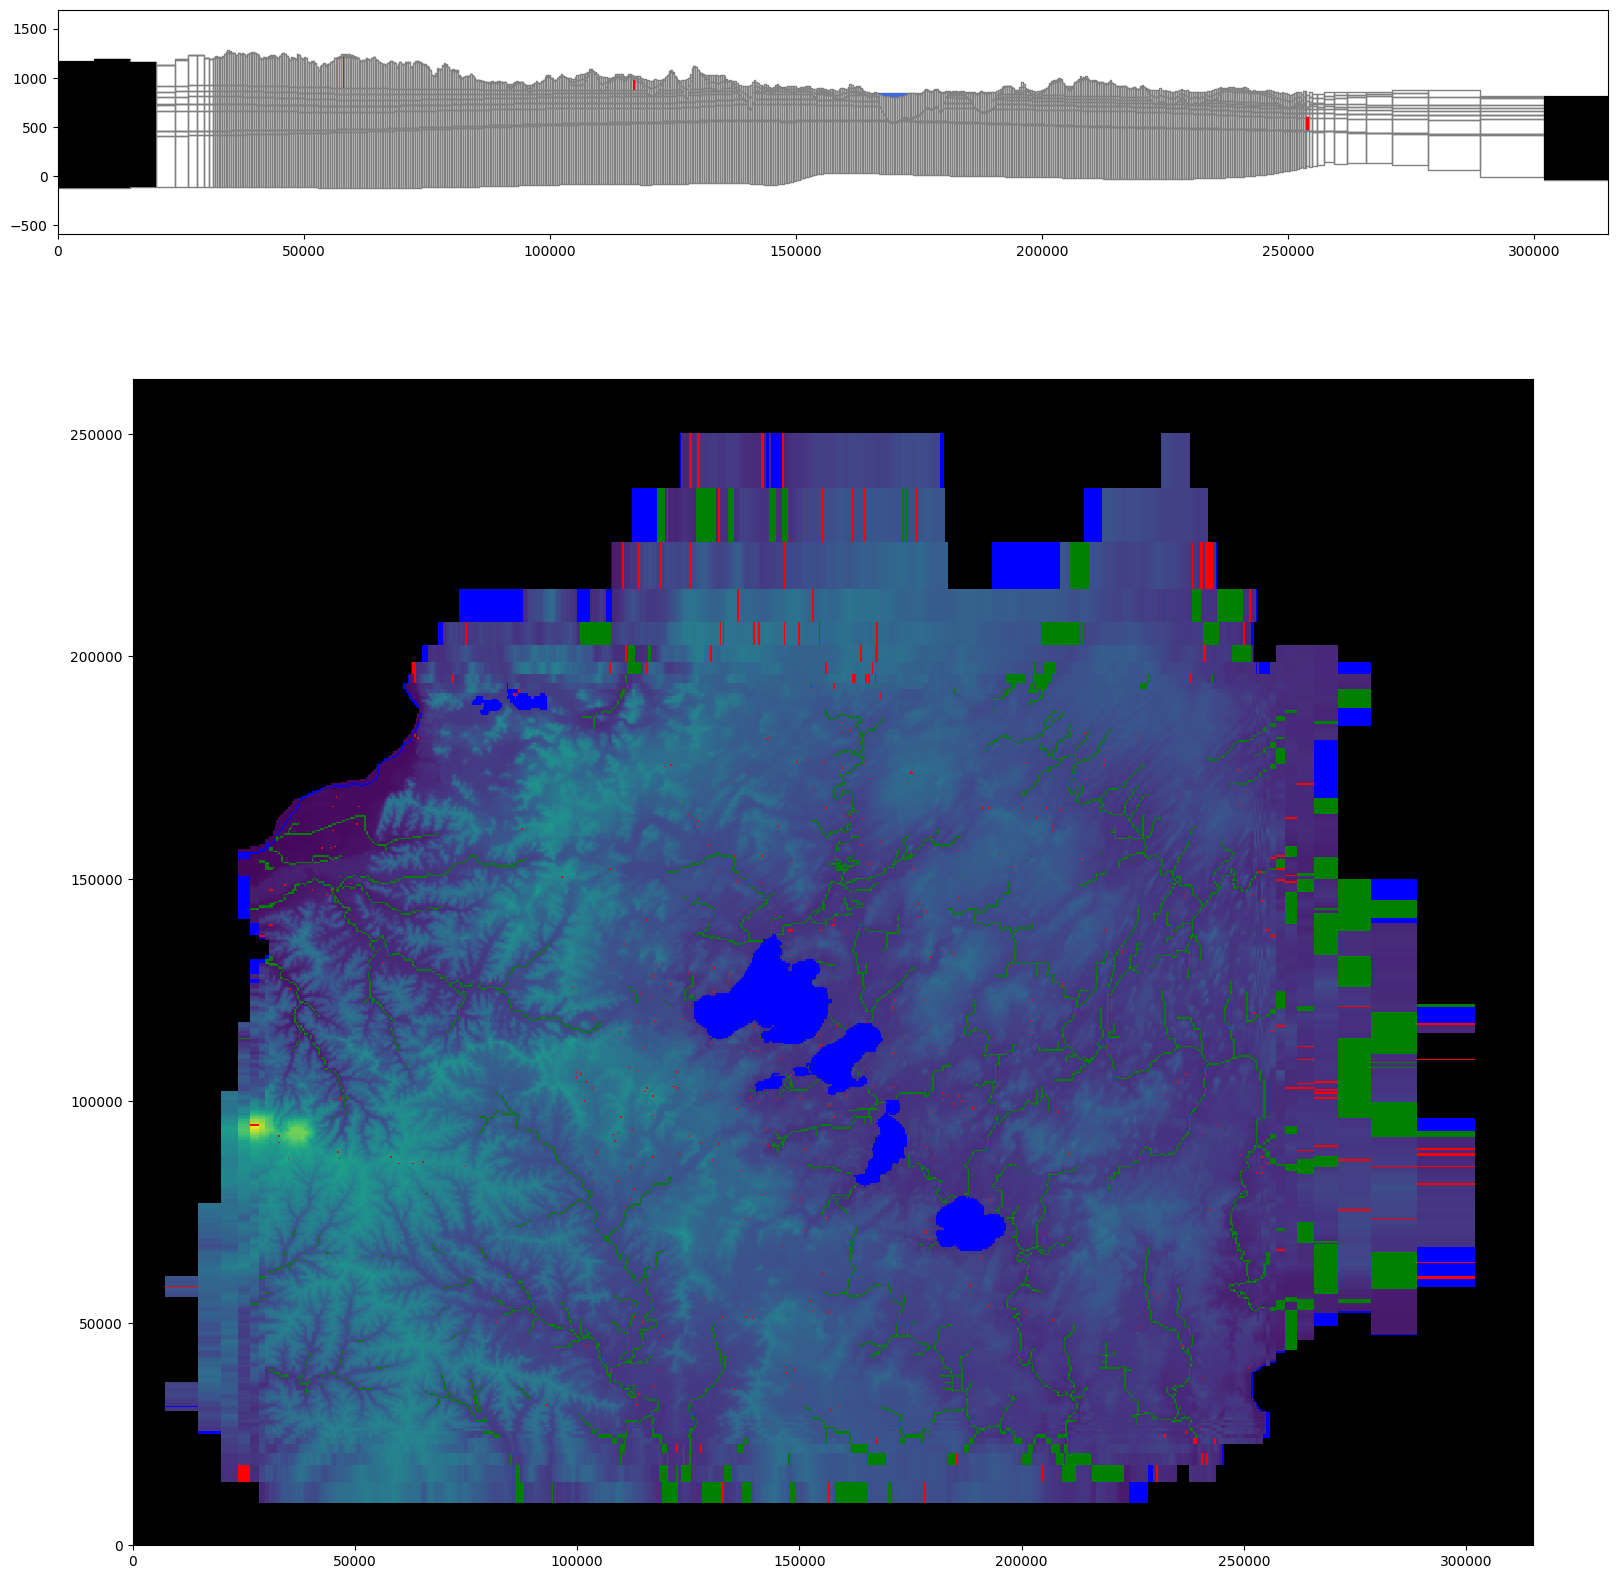

In [132]:
#Examples of accessing different arrays on the grid
#Unfortunately, packages within a model object don't necessarily show up when you're using auto-complete.
top_array = model.dis.top.array
hk_array = model.upw.hk.array

fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(20,20),height_ratios=[0.2,1])
vert_exag = 20
#Row 299 contains some of the multinode wells and the lakes
cross = {"row": 299}
axs[0].set_aspect(vert_exag)
#Plot object for a given cross-section. Different plotting functions under this can plot the grid, BCs, and other
pcr = flopy.plot.PlotCrossSection(model=model, ax=axs[0],line=cross,geographic_coords=True)
pcr.plot_grid()
pcr.plot_ibound()
pcr.plot_bc("MNW2",color='red')
pcr.plot_bc("LAK")

axs[1].set_aspect("equal")
pmv = flopy.plot.PlotMapView(model=model,ax=axs[1],layer=0)
pmv.plot_array(top_array)
pmv.plot_ibound()
pmv.plot_bc(name="LAK",color='blue')
#The keyword plotAll=True here makes sure that the boundary condition is plotted regardless of the layer being shown in PlotMapView
pmv.plot_bc(name="MNW2",color='red',plotAll=True)
pmv.plot_bc(name="SFR",color='green')

[<Axes: title={'center': 'botm layer 1'}>,
 <Axes: title={'center': 'botm layer 2'}>,
 <Axes: title={'center': 'botm layer 3'}>,
 <Axes: title={'center': 'botm layer 4'}>,
 <Axes: title={'center': 'botm layer 5'}>,
 <Axes: title={'center': 'botm layer 6'}>,
 <Axes: title={'center': 'botm layer 7'}>,
 <Axes: title={'center': 'botm layer 8'}>,
 <Axes: title={'center': 'botm layer 9'}>,
 <Axes: title={'center': 'botm layer 10'}>,
 <Axes: title={'center': 'botm layer 11'}>,
 <Axes: title={'center': 'botm layer 12'}>]

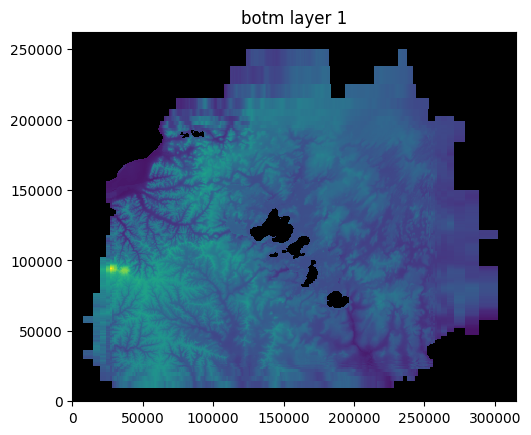

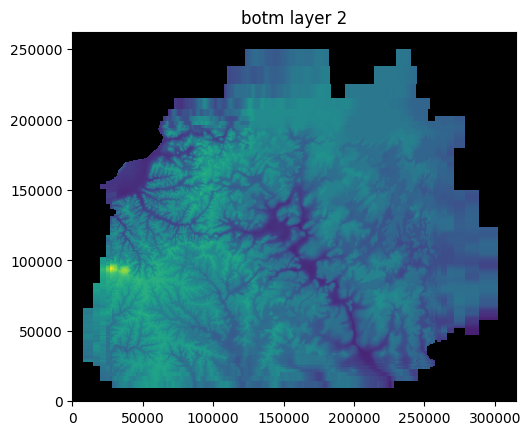

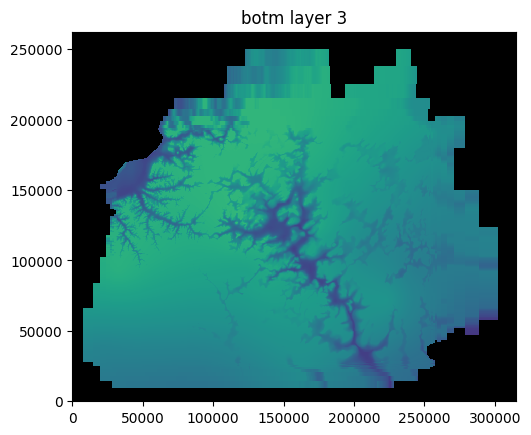

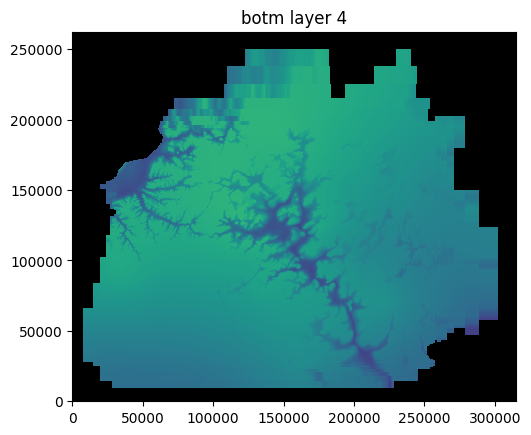

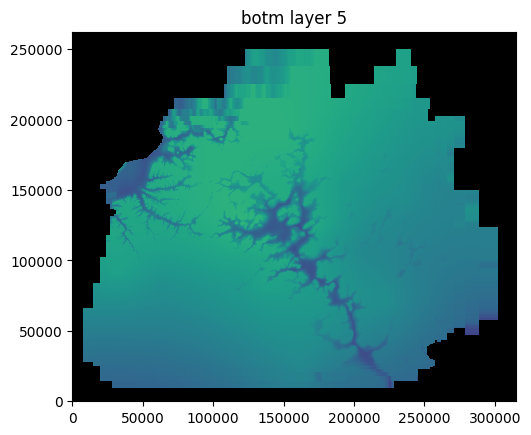

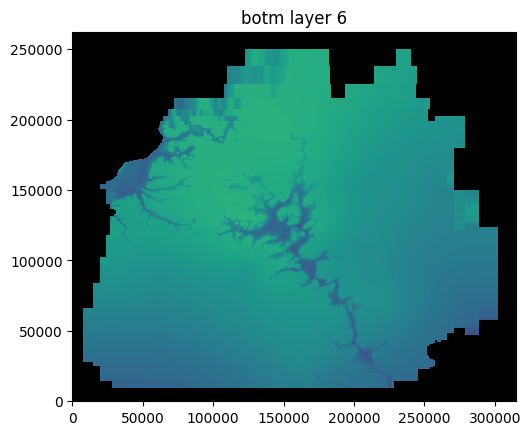

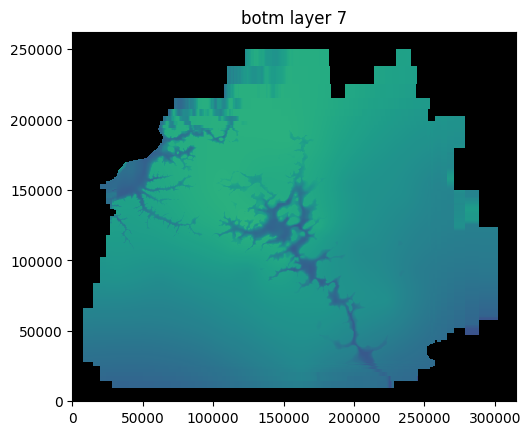

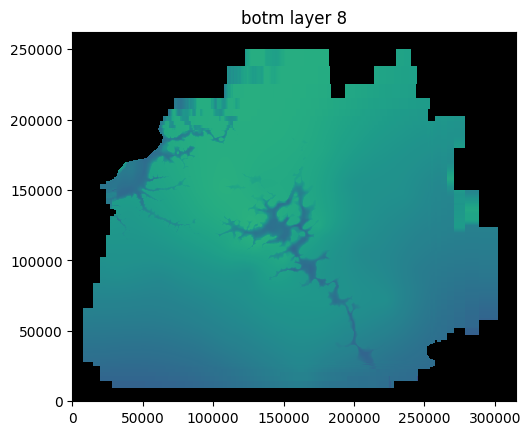

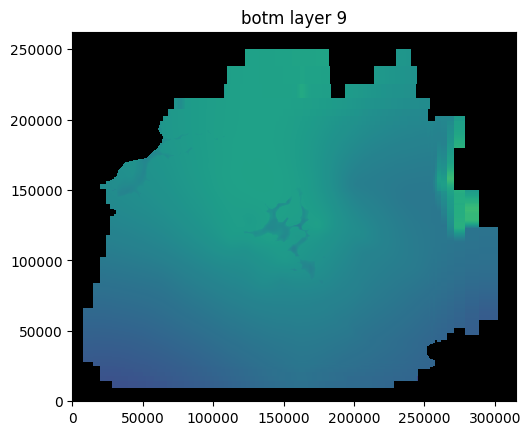

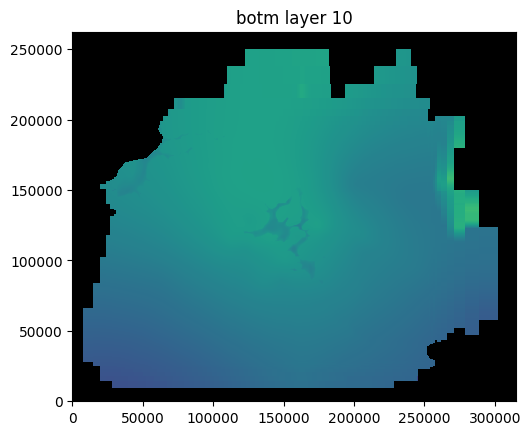

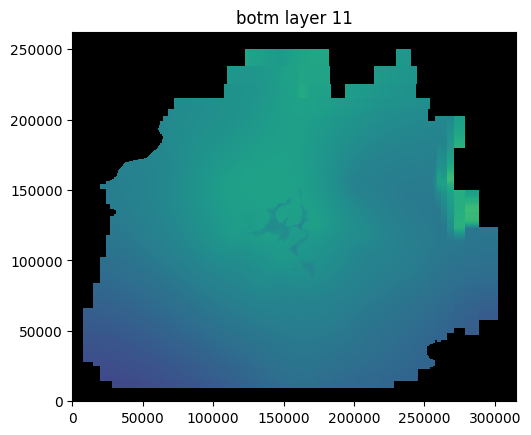

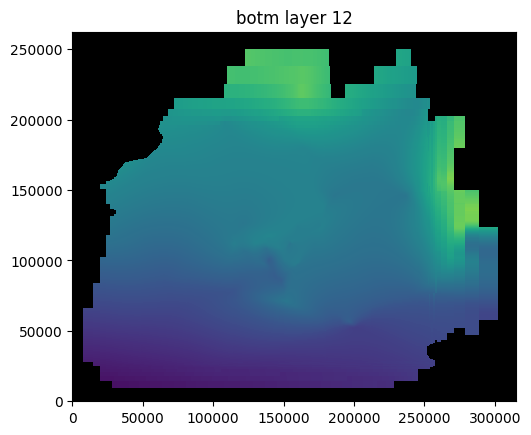

In [114]:
#Another quick method for plotting array-based data for a model
model.dis.botm.plot()

## Step 3: Run the model

As usual, FloPy makes running the model very simple - all that is necessary is to use the `run_model()` method. 

To ensure that everything is running well:
* Verify that the text returned indicates a "Normal termination of simulation"
* Investigate the .LST (List) file contained in your model working directory

In [109]:
model.run_model()

FloPy is using the following executable to run the model: ../../bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: dane2014SS.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/04/01  9:57:56

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/04/01  9:58:44
 Elapsed run time: 48.866 Seconds

  Normal termination of simulation


(True, [])

## Step 4: Processing the model results

The outputs that your model produces will be determined by output control files (usually, a .OC file), which may consist of:
* Head files
* Drawdown files
* Cbb files (cell to cell flows)

These files are often stored as binary files because they would be very large if they were stored as viewable text. To import binary files, use the `flopy.utils.binaryfile` utility.

While the files themselves can be viewed "raw", most often we want to perform some post-processing to generate better visuals. For example, in the case of heads, we may not want to show all dry cells and instead want to show the elevation of the water table. Similarly, instead of displaying cell-to-cell flows exactly, we may want to process these to display flow vectors. 

Routines found within `flopy.utils.postprocessing` provide some common post-processing routines for model results

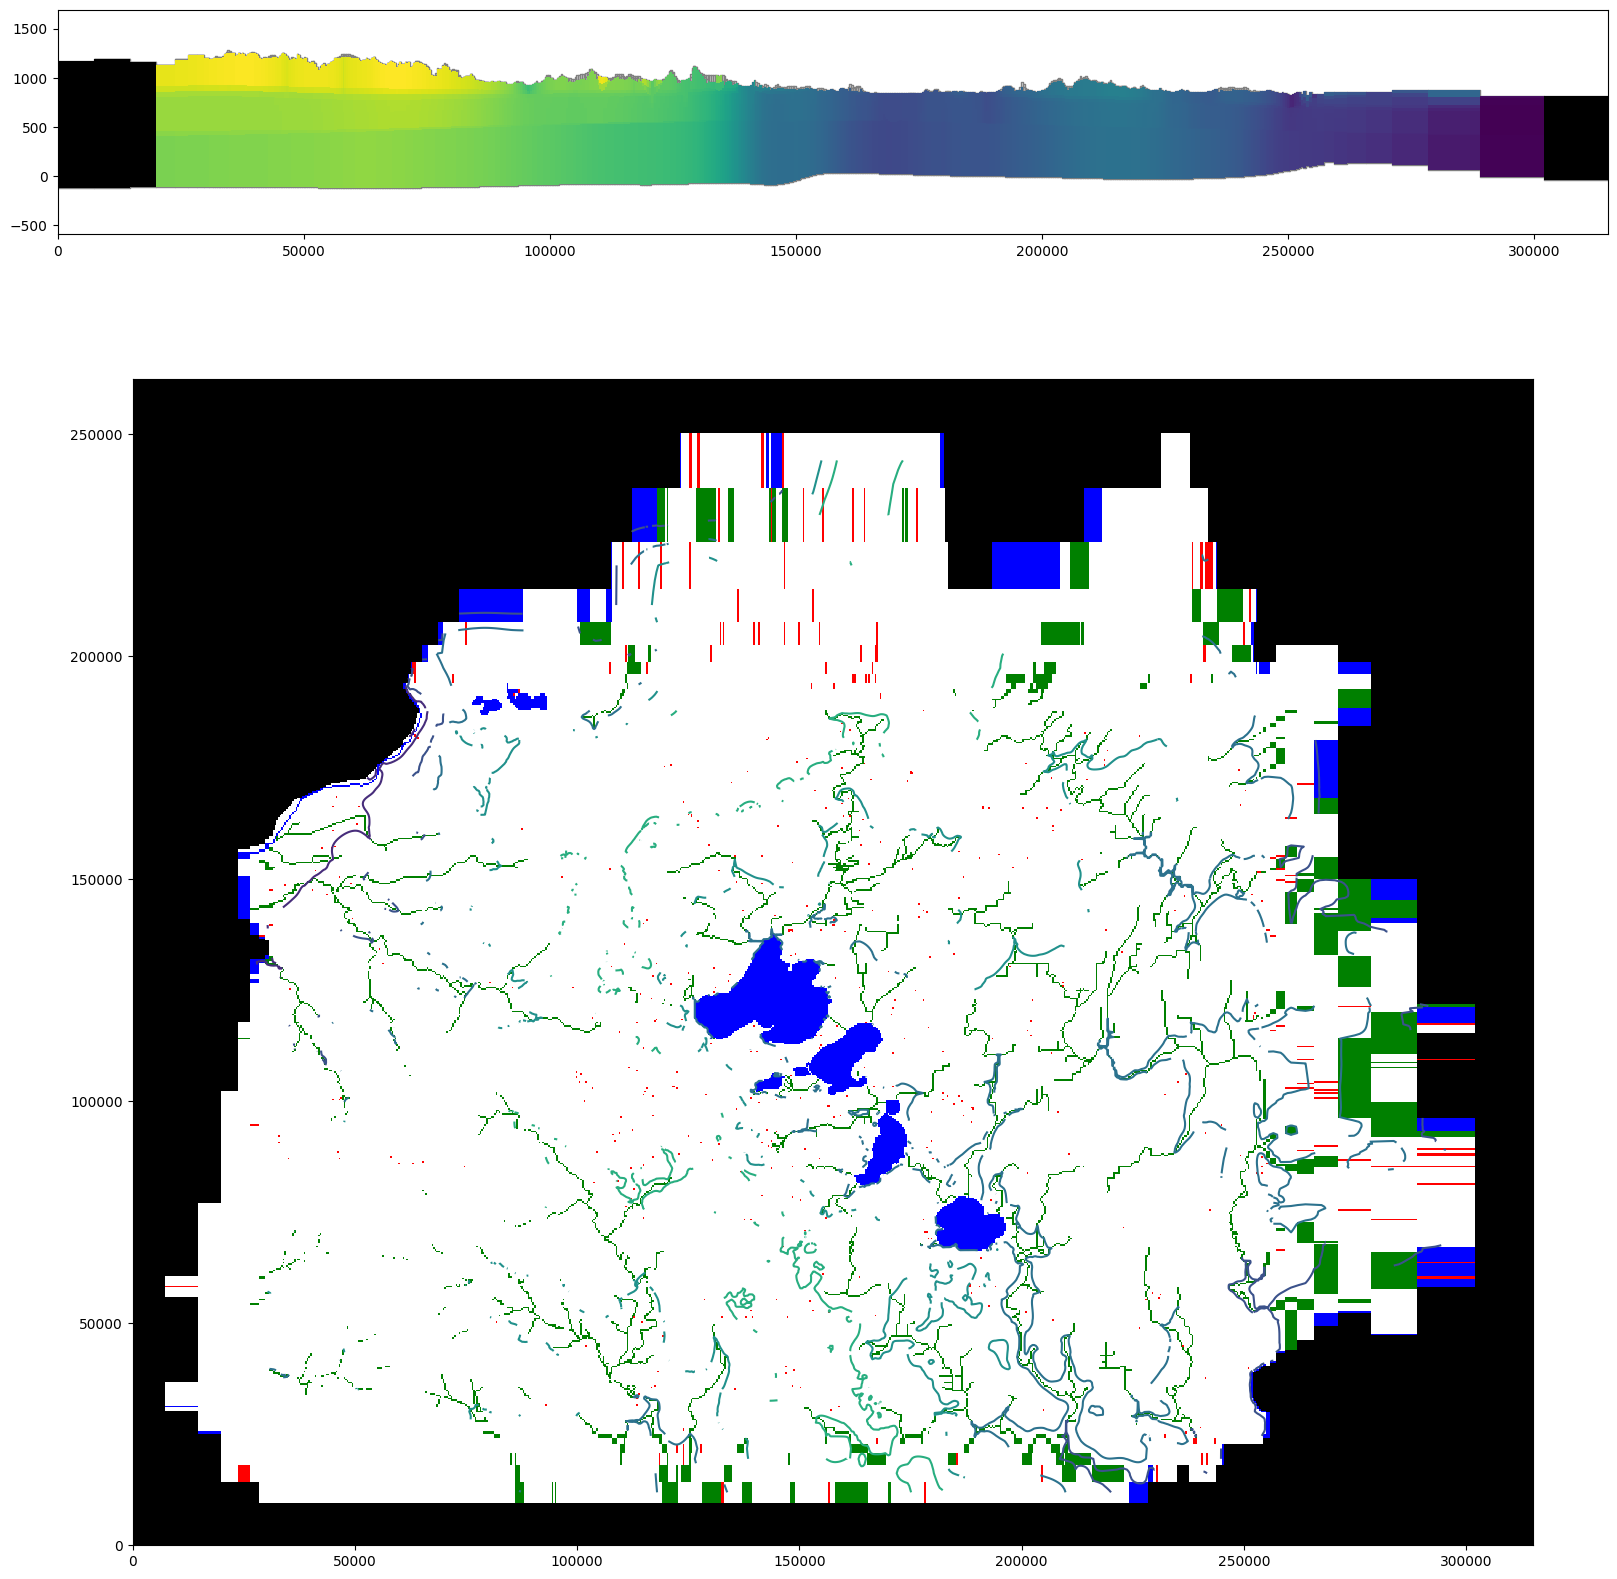

In [144]:
headobj = bf.HeadFile(os.path.join(model_dir,f"{model_nm}.hds"))

#If your model is transient, these steps will allow you to access the last timestep results.
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

#As above, the head object can be simply plotted using the .plot method
#headobj.plot(totim=times[-1], masked_values=[9999.0], colorbar=True)

#Post-process any of the imported data here.
#This utility provides a method for avoiding discontinuous heads per layer
wt = flopy.utils.postprocessing.get_water_table(head)

#Produce new plots, adding the contours of heads to the model
fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(20,20),height_ratios=[0.2,1])
vert_exag = 20
#Row 299 contains some of the multinode wells and the lakes
cross = {"row": 299}
axs[0].set_aspect(vert_exag)
#Plot object for a given cross-section. Different plotting functions under this can plot the grid, BCs, and other
pcr = flopy.plot.PlotCrossSection(model=model, ax=axs[0],line=cross,geographic_coords=True)
pcr.plot_grid()
pcr.plot_ibound()
pcr.plot_bc("MNW2",color='red')
pcr.plot_bc("LAK")
pcr.plot_array(head)
#TODO: What is the difference here?
#pcr.plot_array(head,head=head)

axs[1].set_aspect("equal")
pmv = flopy.plot.PlotMapView(model=model,ax=axs[1],layer=0)
#TODO: Try this approach  to visualize heads
pmv.contour_array(head)
#pmv.contour_array(wt,levels=20)
pmv.plot_ibound()
pmv.plot_bc(name="LAK",color='blue')
#The keyword plotAll=True here makes sure that the boundary condition is plotted regardless of the layer being shown in PlotMapView
pmv.plot_bc(name="MNW2",color='red',plotAll=True)
pmv.plot_bc(name="SFR",color='green')